# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Building the model

In [ ]:
class Neural_Network():
    def __init__(self, neurons, Activations): 
        # arguments: an array "neurons" consist of number of neurons for each layer, 
        # an array "activations" consisting of activation functions used for the hidden layers and output layer
        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] #weights for each layer
        self.biases = [] #biases in each layer 
        self.layer_activations = [] #activations in each layer

        for i in range(len(neurons)-1): 
            self.weights.append(0.01*  np.random.rand(neurons[i+1],neurons[i])) #weight matrix between layer i and layer i+1
#multiplying by 0.01 to avoid vanishing gradients problem
            self.biases.append(  np.random.rand(neurons[i+1],1))
            self.layer_activations.append(Activations[i]) #activations for each layer
        
            
    def sigmoid(self, z): # sigmoid activation function
        #Fill in the details to compute and return the sigmoid activation function                  
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoidPrime(self,z): # derivative of sigmoid activation function
        #Fill in the details to compute and return the derivative of sigmoid activation function
        return self.sigmoid(z)*(1.0 - self.sigmoid(z))

                          
    def tanh(self, z): # hyperbolic tan activation function
        #Fill in the details to compute and return the tanh activation function                  
        return (np.exp(z)- np.exp(-z))/(np.exp(z) + np.exp(-z))
    
    def tanhPrime(self,z): # derivative of hyperbolic tan activation function
        #Fill in the details to compute and return the derivative of tanh activation function
        return 1.0 - (self.tanh(z))**2
                          
    def linear(self, z): # Linear activation function
        #Fill in the details to compute and return the linear activation function                                    
        return z
    
    def linearPrime(self,z): # derivative of linear activation function
        #Fill in the details to compute and return the derivative of activation function                                                      
        return np.ones([z.shape[0], z.shape[1]])

    def ReLU(self,z): # ReLU activation function
        #Fill in the details to compute and return the ReLU activation function                  
        return np.maximum(0,z)
    
    def ReLUPrime(self,z): # derivative of ReLU activation function
        #Fill in the details to compute and return the derivative of ReLU activation function
        return (z>0).astype(z.dtype)
    
    def softmax(self,z):
        return np.exp(z)/np.sum(np.exp(z), axis = 0)
    
    def forward(self, a, softmax = True): # function of forward pass which will receive input and give the output of final layer
        # Write the forward pass using the weights and biases to find the predicted value and return them.
        layer_activations_a = [a] #store the input as the input layer activations
        layer_dot_prod_z = []
        for i, param in enumerate(zip(self.biases, self.weights)):
            b, w = param[0], param[1]
            if self.layer_activations[i].lower()=='sigmoid':
                z = np.dot(w, a)+b
                a = self.sigmoid(z)
            elif self.layer_activations[i].lower()=='relu':
                z = np.dot(w, a)+ b
                a = self.ReLU(z)
            elif self.layer_activations[i].lower()=='tanh':   
                z = np.dot(w, a)+b
                a = self.tanh(z)
            elif self.layer_activations[i].lower()=='linear':
                z = np.dot(w, a)+b
                a = self.linear(z)
            
            layer_dot_prod_z.append(z)    
            layer_activations_a.append(a)
            
        if softmax == True:
            y_hat = self.softmax(a)
        else:
            y_hat = []
            
        return a, layer_dot_prod_z, layer_activations_a , y_hat
                          
            
    
    def backward(self, x, y, zs, activations, softmax = False): # find the loss and return derivative of loss w.r.t every parameter
        # Write the backpropagation algorithm here to find the gradients of weights and biases and return them.
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        if self.layer_activations[-1].lower()=='sigmoid':
            prime_last = self.sigmoidPrime(zs[-1])
        elif self.layer_activations[-1].lower()=='relu':
            prime_last = self.ReLUPrime(zs[-1])
        elif self.layer_activations[-1].lower()=='tanh':   
            prime_last = self.tanhPrime(zs[-1])
        elif self.layer_activations[-1].lower()=='linear':
            prime_last = self.linearPrime(zs[-1])

        
        # fill in the appropriate details for gradients of w and b
        if softmax == True:
            delta = self.softmax(activations[-1]) - y
        else:
            delta = activations[-1] - y
        grad_b[-1] = np.matmul(np.diagflat(prime_last), delta)
        grad_w[-1] = np.matmul(np.matmul(np.diagflat(prime_last), delta), activations[-2].T)
                 
        for l in range(2, self.layers): # Here l is in backward sense i.e. last l th layer
            z = zs[-l]
            if self.layer_activations[-l].lower()=='sigmoid':
                prime = self.sigmoidPrime(z)
            elif self.layer_activations[-l].lower()=='relu':
                prime = self.ReLUPrime(z)
            elif self.layer_activations[-l].lower()=='tanh':   
                prime = self.tanhPrime(z)
            elif self.layer_activations[-l].lower()=='linear':
                prime = self.linearPrime(z)
                
            #To access next layer activation derivatives of activations w.r.t z    
            z_next = zs[-l+1]
            if self.layer_activations[-l+1].lower()=='sigmoid':
                prime_next_la = self.sigmoidPrime(z_next)
            elif self.layer_activations[-l+1].lower()=='relu':
                prime_next_la = self.ReLUPrime(z_next)
            elif self.layer_activations[-l+1].lower()=='tanh':   
                prime_next_la = self.tanhPrime(z_next)
            elif self.layer_activations[-l+1].lower()=='linear':
                prime_next_la = self.linearPrime(z_next)
                

            delta = np.matmul(np.matmul((self.weights[-l+1]).T , np.diagflat(prime_next_la)), delta)
            grad_b[-l] = np.matmul(np.diagflat(prime), delta)
            grad_w[-l] = np.matmul(np.matmul(np.diagflat(prime), delta) , activations[-l-1].T)

        return (grad_b, grad_w)                 

    def update_parameters(self, grads, learning_rate): # update the parameters using the gradients
        # update weights and biases using the gradients and the learning rate
        grad_b, grad_w = grads[0], grads[1]       
        #Implement the update rule for weights  and biases
        assert len(self.weights) == len(grad_w)
        assert self.weights[2].shape == grad_w[2].shape
        assert len(self.biases) == len(grad_b)
#         print('Weight before update:', self.weights[2])
        self.weights = [self.weights[i] - learning_rate * grad_w[i] for i in range(len(self.weights))]
        self.biases = [self.biases[k] - learning_rate * grad_b[k] for k in range(len(self.biases))]
#         print('Weight after update', self.weights[2])

        
    def loss(self, predicted, actual):
        #Implement the loss function
        return 0.5*(predicted-actual)**2
    
    def CrossEntropyLoss(self, predicted, actual):
        Loss = 0
        for i in range(actual.shape[0]):
            if actual[i] != 0:
                L = -1 * actual[i]* np.log(predicted[i])
                Loss = Loss + L
        return Loss
    

######Q4(b) - Implementing Cross Entropy and suared error loss functions for partition #######

    def partitionloss_SE(self, X_val, Y_val, softmax = False):
        Loss = 0
        for i in range(len(X_val)):
            X_val_ = np.resize(X_val[i], (X_val[i].shape[0], 1))
            output,_,_,_ = self.forward(X_val_, softmax = softmax)
            Loss = Loss + self.loss(output, Y_val[i])
        return np.divide(Loss, X_val.shape[0]) 
    
#     def partitionloss_CE:
#         pass

    
                     
    def train(self, X, Y, lr, epochs, minibatchsize , minibatch=False, softmax = False, crossentropy=False, onehotencoded = False): # receive the full training data set
        lr = lr         # learning rate
        epochs = epochs     # number of epochs
        loss_list = []
        if minibatch==False:
            for e in range(epochs): 
                losses = []
                for q in range(len(X)):
                    train_x = np.resize(X[q],(X[q].shape[0],1)) 
                    if not onehotencoded: 
                        train_y = np.resize(Y[q],(1,1)) 
                    else:
                        train_y = np.resize(np.argmax(Y[q]),(1,1)) 
                    out, dot_prod_z, activations_a = self.forward(train_x)
                    if crossentropy == False:
                        loss = self.loss(out, train_y)
                    else:
                        loss = self.CrossEntropyLoss(out, train_y)
                    grads = self.backward(train_x, train_y, dot_prod_z, activations_a) # find the gradients using backward pass
                    self.update_parameters(grads, lr)
                    losses.append(loss)
                loss_list.append(np.mean(np.array(losses)))
                print(f'Epoch: {e} Loss: {np.mean(np.array(losses))}')
        else:
            minibatchsize = minibatchsize
            X_mb, Y_mb = create_minibatches(X,Y,minibatchsize)   
            for e in range(epochs):
                loss_list1 = []
                for batch in range(len(X_mb)):
                    losses = []
                    train_x, train_y = X_mb[batch], Y_mb[batch] 
                    grad_b_m, grad_w_m = [], []
                    
                    for k in range(len(train_x)):
                        train_x_ = np.resize(train_x[k],(train_x[k].shape[0],1))
                        if not onehotencoded:
                            train_y_ = np.resize(np.argmax(train_y[k]),(1,1))
                        else:
                            train_y_ = np.resize(train_y[k],(train_y[k].shape[0],1))
                        if softmax == True:
                            out, dot_prod_z, activations_a, y_hat = self.forward(train_x_, softmax = True)
                            if crossentropy == False:
                                loss = self.loss(out, train_y_)
                            else:
                                loss = self.CrossEntropyLoss(y_hat, train_y_)
                            grads = self.backward(train_x_, train_y_, dot_prod_z, activations_a, softmax = True) # find the gradients using backward pass 
                        else:
                            out, dot_prod_z, activations_a, y_hat = self.forward(train_x_, softmax = False)
                            if crossentropy == False:
                                loss = self.loss(out, train_y_)
                            else:
                                loss = self.CrossEntropyLoss(y_hat, train_y_)
                            grads = self.backward(train_x_, train_y_, dot_prod_z, activations_a, softmax = False) # find the gradients using backward pass 
                        grad_b, grad_w = grads[0], grads[1]
                        grad_b_m.append(grad_b)
                        grad_w_m.append(grad_w)
                        losses.append(loss)
#                     grad_w_mb =np.divide(sum(np.array(grad_w_m)), len(grad_w_m))
#                     grad_b_mb = np.divide(sum(np.array(grad_b_m)), len(grad_b_m))
                    grad_w_mb =sum(np.array(grad_w_m))
                    grad_b_mb = sum(np.array(grad_b_m))
                    grad_minibatch = (list(grad_b_mb), list(grad_w_mb))
                    self.update_parameters(grad_minibatch, lr)
                    loss_list1.append(np.mean(np.array(losses)))
                    
                    
                loss_list.append(np.mean(np.array(loss_list1)))
                print(f'Epoch: {e} Loss: {np.mean(np.array(loss_list1))}')
        return loss_list


    
  
    
    def predict(self, x, softmax = True):
        prediction,_,_,y_hat = self.forward(x, softmax = softmax )
        if softmax == True:
            return x, y_hat
        else:
            return x, prediction
        


# One-hot-Encoding and Mini-Batch

In [ ]:
# a method for creating one hot encoded labels 

def onehotencoding(Y):
    Y_ohe = np.zeros([Y.shape[0], Y.max()+1])
    Y_ohe[np.arange(Y.shape[0]), Y] = 1
    return Y_ohe

#a method to create minibatches 
def create_minibatches(X,Y,minibatchsize):
    numbatches = int(np.ceil(len(X)/minibatchsize))
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X_minibatches = []
    Y_minibatches = [] 
    for i in range(numbatches):
        idx_minibatch = idx[i*minibatchsize:min(len(idx),(i+1)*minibatchsize)]
        xn = np.take(X,idx_minibatch,axis=0) 
        yn = np.take(Y,idx_minibatch,axis=0)
        X_minibatches.append(xn)
        Y_minibatches.append(yn)
    return X_minibatches, Y_minibatches

def test_create_minibatches():
    X = []
    Y = []
    inputsize = 3
    minibatch = False
    onehotencoded = False
    n_batch = 20
    batch_size = 5
    for i in range(50):
        if(i % 2 == 0):
            X.append([np.random.randint(1,10) for i1 in range(inputsize)])
            Y.append(1)
        else:
            X.append([np.random.randint(-10,1) for i1 in range(inputsize)])
            Y.append(0)
    X = np.array(X)
    Y = np.array(Y)

    X_mb, Y_mb = create_minibatches(X,Y,6)
test_create_minibatches()


# DIGITS Dataset

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(digits.images.shape)
digits.images[1]

(1797, 64)
(1797, 8, 8)


array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

Label:  0


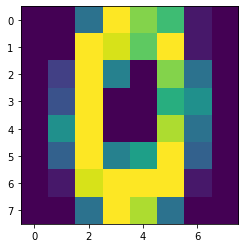

In [ ]:
#~1797 8X8 images
eg_img = 1793
import matplotlib.pyplot as plt
plt.imshow(digits.images[eg_img])
print('Label: ', digits.target[eg_img])

In [ ]:
#labels
target = digits.target
print(target)
np.unique(target, return_counts = True)

[0 1 2 ... 8 9 8]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [ ]:
data = digits.data
print(np.min(data), np.max(data))
target = digits.target
train_X = data
train_Y = onehotencoding(target)
Z = (train_X.shape, train_Y.shape)
print(Z)

0.0 16.0
((1797, 64), (1797, 10))


# I. Neural Network with Cross Entropy Loss 

## Defining the network

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet = Neural_Network(neurons, activation_functions)

(Using Softmax function on activations of the output layer)

## Training the network

In [ ]:
Loss = crossentropy_neuralnet.train(train_X, train_Y, 0.0001, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)

Epoch: 0 Loss: 2.3339290196307694
Epoch: 1 Loss: 2.3314015496083402
Epoch: 2 Loss: 2.3292840911456802
Epoch: 3 Loss: 2.3272064375869834
Epoch: 4 Loss: 2.3251494046438332
Epoch: 5 Loss: 2.3230928843261736
Epoch: 6 Loss: 2.321015228303317
Epoch: 7 Loss: 2.3188925069525843
Epoch: 8 Loss: 2.3166975850266835
Epoch: 9 Loss: 2.3143989297350043
Epoch: 10 Loss: 2.3119590271309702
Epoch: 11 Loss: 2.3093322184653045
Epoch: 12 Loss: 2.3064616625937764
Epoch: 13 Loss: 2.303274952496279
Epoch: 14 Loss: 2.2996776046530125
Epoch: 15 Loss: 2.2955430841323423
Epoch: 16 Loss: 2.290697080963529
Epoch: 17 Loss: 2.2848920014412664
Epoch: 18 Loss: 2.2777652657219174
Epoch: 19 Loss: 2.2687663908812827
Epoch: 20 Loss: 2.2570370557148456
Epoch: 21 Loss: 2.2412983506506414
Epoch: 22 Loss: 2.2198304149566974
Epoch: 23 Loss: 2.190683646926374
Epoch: 24 Loss: 2.1524998556623345
Epoch: 25 Loss: 2.1066060747173685
Epoch: 26 Loss: 2.057390762051379
Epoch: 27 Loss: 2.009459881736673
Epoch: 28 Loss: 1.9644159118590223
E

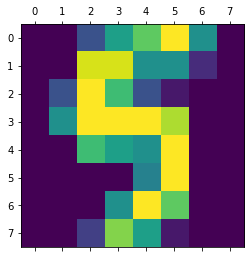

Input: [[ 0.  0.  4.  9. 12. 16.  8.  0.  0.  0. 15. 15.  8.  8.  2.  0.  0.  4.
  16. 11.  4.  1.  0.  0.  0.  8. 16. 16. 16. 14.  0.  0.  0.  0. 11.  9.
   8. 16.  0.  0.  0.  0.  0.  0.  7. 16.  0.  0.  0.  0.  0.  8. 16. 12.
   0.  0.  0.  0.  3. 13.  9.  1.  0.  0.]]
Actual Label: 5
Predicted Label: 5
[0 1 2 ... 8 9 8]
[0 1 2 ... 8 9 8]
Accuracy:98.8313856427379%  Number of correctly predicted samples:1776


In [ ]:
tr_eg = 1700
X_data, predict = crossentropy_neuralnet.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= True)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Input:', np.resize(X_data, (1, X_data.shape[0])))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))
print('Predicted Label:', np.argmax(predict, axis = 0)[0])

#Accuracy
prediction =[]
for i in range(1797):
    _, b = crossentropy_neuralnet.predict(np.array(train_X[i]).reshape(64,1), softmax= True);
    k = np.argmax(b, axis=0)[0];
    prediction.append(k)
print(np.array(prediction))
print(target)

from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction)*100)+'%' + '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction, normalize = False)))

#### The accuracy is 98.9%  on training

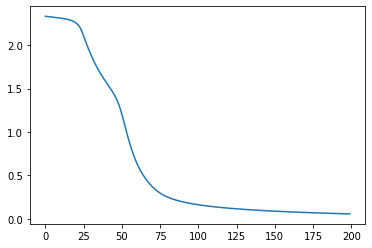

In [ ]:
x = [i for i in range(len(Loss))]
plt.plot(x, Loss)
plt.show()

# II. Neural Network with Squared Error Loss


### 1. Defining the network

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet = Neural_Network(neurons, activation_functions)


### 2. Training the network

In [ ]:
Loss_SE = squarederror_neuralnet.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 1 , minibatch = True, softmax = False , crossentropy = False, onehotencoded = False )

Epoch: 0 Loss: 4.122099147801432
Epoch: 1 Loss: 3.312611300129885
Epoch: 2 Loss: 2.4057838448244966
Epoch: 3 Loss: 2.0692138817680124
Epoch: 4 Loss: 1.9132602608628937
Epoch: 5 Loss: 1.8018853345489332
Epoch: 6 Loss: 1.7046324777893598
Epoch: 7 Loss: 1.612472578229429
Epoch: 8 Loss: 1.520601857323667
Epoch: 9 Loss: 1.4311889262649273
Epoch: 10 Loss: 1.3474929146357677
Epoch: 11 Loss: 1.2725366691657778
Epoch: 12 Loss: 1.2092620571780823
Epoch: 13 Loss: 1.1563584023480586
Epoch: 14 Loss: 1.1121583013144385
Epoch: 15 Loss: 1.0747527972450124
Epoch: 16 Loss: 1.0420812807978796
Epoch: 17 Loss: 1.0129374915978333
Epoch: 18 Loss: 0.9859661223495604
Epoch: 19 Loss: 0.960921508226171
Epoch: 20 Loss: 0.9374292423389355
Epoch: 21 Loss: 0.9148515279407484
Epoch: 22 Loss: 0.8925973207019137
Epoch: 23 Loss: 0.8706346544821058
Epoch: 24 Loss: 0.8497003683299362
Epoch: 25 Loss: 0.8268584056245559
Epoch: 26 Loss: 0.8047279932976377
Epoch: 27 Loss: 0.7825868249002529
Epoch: 28 Loss: 0.7605070010263953


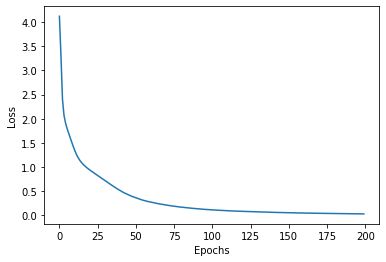

In [ ]:
plt.plot(Loss_SE)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Predicting a data point 

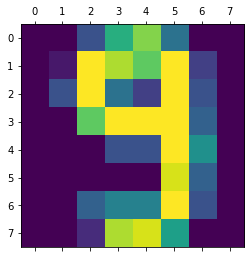

Output: [[8.86365525]]
Prediction: 9
Actual Label: 9
[ 0  0  2 ...  8 10  7]
[0 1 2 ... 8 9 8]
Accuracy:84.30717863105176%  Number of correctly predicted samples:1515


In [ ]:
#Prediction Rule- Rounding to the nearest integer

tr_eg = 1792
a, pred = squarederror_neuralnet.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred)
print('Prediction:', int(np.round(pred)))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))


#Accuracy
prediction1 =[]
for i in range(train_X.shape[0]):
    _, b = squarederror_neuralnet.predict(np.array(train_X[i]).reshape(64,1), softmax= False);
    t = int(np.round(b)[0]);
    prediction1.append(t)
print(np.array(prediction1))
print(target)
from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction1)*100)+'%' + '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction1, normalize = False)))

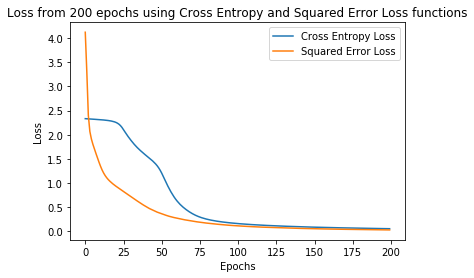

In [ ]:
plt.plot(Loss, label = "Cross Entropy Loss")
plt.plot(Loss_SE, label = "Squared Error Loss")
plt.legend(loc = 'upper right')
plt.title("Loss from 200 epochs using Cross Entropy and Squared Error Loss functions")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Normalizing the input data

In [ ]:
#Max-min normalization

data = digits.data
print(np.min(data), np.max(data))
target = digits.target
train_X = np.divide(data, np.max(data))
train_Y = onehotencoding(target)
Z = (train_X.shape, train_Y.shape)
print(Z)

0.0 16.0
((1797, 64), (1797, 10))


In [ ]:
print(train_X)

[[0.     0.     0.3125 ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.625  0.     0.    ]
 [0.     0.     0.     ... 1.     0.5625 0.    ]
 ...
 [0.     0.     0.0625 ... 0.375  0.     0.    ]
 [0.     0.     0.125  ... 0.75   0.     0.    ]
 [0.     0.     0.625  ... 0.75   0.0625 0.    ]]


#Squared Error Loss - Varying Learning Rates

### I. Learning Rate - 0.1

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet1 = Neural_Network(neurons, activation_functions)
Loss_SE1 = squarederror_neuralnet1.train(train_X, train_Y, lr = 0.1, epochs = 200, minibatchsize = 1 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 6.33335941568331
Epoch: 1 Loss: 4.324572307521381
Epoch: 2 Loss: 4.324572307521381
Epoch: 3 Loss: 4.324572307521381
Epoch: 4 Loss: 4.324572307521381
Epoch: 5 Loss: 4.324572307521381
Epoch: 6 Loss: 4.324572307521381
Epoch: 7 Loss: 4.324572307521381
Epoch: 8 Loss: 4.324572307521381
Epoch: 9 Loss: 4.324572307521381
Epoch: 10 Loss: 4.324572307521381
Epoch: 11 Loss: 4.324572307521381
Epoch: 12 Loss: 4.324572307521381
Epoch: 13 Loss: 4.324572307521381
Epoch: 14 Loss: 4.324572307521381
Epoch: 15 Loss: 4.324572307521381
Epoch: 16 Loss: 4.324572307521381
Epoch: 17 Loss: 4.324572307521381
Epoch: 18 Loss: 4.324572307521381
Epoch: 19 Loss: 4.324572307521381
Epoch: 20 Loss: 4.324572307521381
Epoch: 21 Loss: 4.324572307521381
Epoch: 22 Loss: 4.324572307521381
Epoch: 23 Loss: 4.324572307521381
Epoch: 24 Loss: 4.324572307521381
Epoch: 25 Loss: 4.324572307521381
Epoch: 26 Loss: 4.324572307521381
Epoch: 27 Loss: 4.324572307521381
Epoch: 28 Loss: 4.324572307521381
Epoch: 29 Loss: 4.3245723

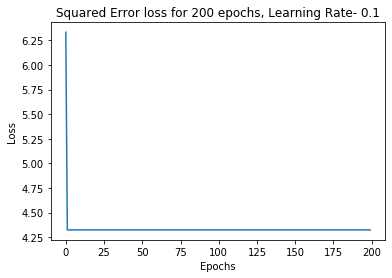

In [ ]:
plt.plot(Loss_SE1)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.1")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## II. Learning Rate - 0.01

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet2 = Neural_Network(neurons, activation_functions)
Loss_SE2 = squarederror_neuralnet2.train(train_X, train_Y, lr = 0.01, epochs =200, minibatchsize=1 , minibatch = True, crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 3.350178118693481
Epoch: 1 Loss: 1.9845959448812538
Epoch: 2 Loss: 1.3666708307070956
Epoch: 3 Loss: 0.97220399397278
Epoch: 4 Loss: 0.7538653105176317
Epoch: 5 Loss: 0.5948354915380217
Epoch: 6 Loss: 0.4954952872527066
Epoch: 7 Loss: 0.432844541189491
Epoch: 8 Loss: 0.3776382943305031
Epoch: 9 Loss: 0.3497535071179676
Epoch: 10 Loss: 0.3246390248662324
Epoch: 11 Loss: 0.2890057934578702
Epoch: 12 Loss: 0.26302844822375193
Epoch: 13 Loss: 0.23683242158389112
Epoch: 14 Loss: 0.22047964061634567
Epoch: 15 Loss: 0.20296594054554568
Epoch: 16 Loss: 0.18478668473028842
Epoch: 17 Loss: 0.16716425347087108
Epoch: 18 Loss: 0.15077813381160143
Epoch: 19 Loss: 0.13821553593759925
Epoch: 20 Loss: 0.11794956243419794
Epoch: 21 Loss: 0.12392868521101862
Epoch: 22 Loss: 0.11282490382323351
Epoch: 23 Loss: 0.09271251782966874
Epoch: 24 Loss: 0.079827442760586
Epoch: 25 Loss: 0.06837270105844136
Epoch: 26 Loss: 0.059477222550399736
Epoch: 27 Loss: 0.05274496523743132
Epoch: 28 Loss: 0.0

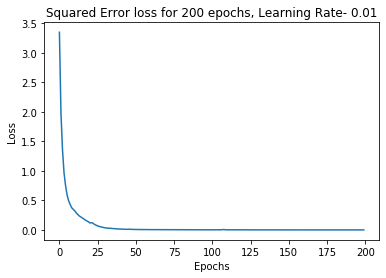

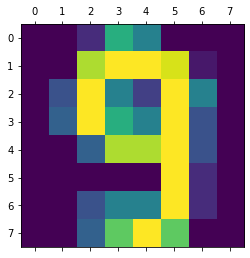

Output: [[8.90070869]]
Prediction: [[9.]]
Actual Label: 9
[ 0  1  2 ... 10  8  7]
[0 1 2 ... 8 9 8]
Correctly predicted examples:1286  Accuracy:71.56371730662214%


In [ ]:
plt.plot(Loss_SE2)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.01")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


#Prediction Rule- Rounding to the nearest integer

tr_eg = 1795
a, pred1 = squarederror_neuralnet2.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred1)
print('Prediction:', np.round(pred1))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))

#Accuracy
prediction1 =[]
for i in range(train_X.shape[0]):
    _, b = squarederror_neuralnet3.predict(np.array(train_X[i]).reshape(64,1), softmax= False);
    t = int(np.round(b)[0]);
    prediction1.append(t)
print(np.array(prediction1))
print(target)
from sklearn.metrics import accuracy_score
print('Correctly predicted examples:'+ str(accuracy_score(target, prediction1, normalize = False))+'  Accuracy:'+ str(accuracy_score(target, prediction1)*100)+'%' )

## III. Learning Rate- 0.001

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet3 = Neural_Network(neurons, activation_functions)
Loss_SE3 = squarederror_neuralnet3.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 1 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 4.368774725625894
Epoch: 1 Loss: 4.047161973382362
Epoch: 2 Loss: 2.94101501595967
Epoch: 3 Loss: 2.1509615575012337
Epoch: 4 Loss: 1.9607193455809426
Epoch: 5 Loss: 1.8342975630076546
Epoch: 6 Loss: 1.7178224328644867
Epoch: 7 Loss: 1.6108700874226074
Epoch: 8 Loss: 1.5109532165332913
Epoch: 9 Loss: 1.414892011871027
Epoch: 10 Loss: 1.3206784087771137
Epoch: 11 Loss: 1.2417454460008845
Epoch: 12 Loss: 1.1797933971825294
Epoch: 13 Loss: 1.1321886088761526
Epoch: 14 Loss: 1.0929253178362073
Epoch: 15 Loss: 1.0589210777658329
Epoch: 16 Loss: 1.02799809509434
Epoch: 17 Loss: 0.999514735181026
Epoch: 18 Loss: 0.9739152901529198
Epoch: 19 Loss: 0.9482289825911261
Epoch: 20 Loss: 0.925584831677042
Epoch: 21 Loss: 0.9054971457484586
Epoch: 22 Loss: 0.8835846923564781
Epoch: 23 Loss: 0.864238305738176
Epoch: 24 Loss: 0.8474831857840774
Epoch: 25 Loss: 0.8299775882891016
Epoch: 26 Loss: 0.8128001938119559
Epoch: 27 Loss: 0.7960035363519274
Epoch: 28 Loss: 0.7784579189064298
Epoch

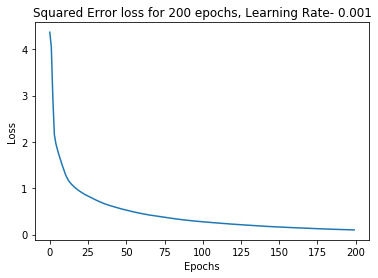

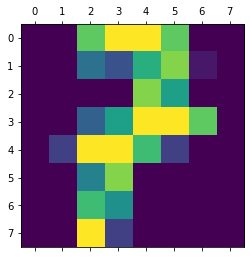

Output: [[6.61178418]]
Prediction: [[7.]]
Actual Label: 7
[ 0  1  2 ... 10  8  7]
[0 1 2 ... 8 9 8]
Accuracy:71.56371730662214%


In [ ]:
plt.plot(Loss_SE3)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1200
a, pred1 = squarederror_neuralnet3.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred1)
print('Prediction:', np.round(pred1))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))

#Accuracy
prediction1 =[]
for i in range(train_X.shape[0]):
    _, b = squarederror_neuralnet3.predict(np.array(train_X[i]).reshape(64,1), softmax= False);
    t = int(np.round(b)[0]);
    prediction1.append(t)
print(np.array(prediction1))
print(target)
from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction1)* 100)+'%' )

## IV. Learning Rate- 0.0001

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet6 = Neural_Network(neurons, activation_functions)
Loss_SE6 = squarederror_neuralnet6.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 1 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 4.2587269937360475
Epoch: 1 Loss: 4.14633317581837
Epoch: 2 Loss: 4.133775064964098
Epoch: 3 Loss: 4.121188908276982
Epoch: 4 Loss: 4.108472267861586
Epoch: 5 Loss: 4.09552094829482
Epoch: 6 Loss: 4.0822270208305556
Epoch: 7 Loss: 4.06847638803933
Epoch: 8 Loss: 4.054145724707035
Epoch: 9 Loss: 4.039098592306026
Epoch: 10 Loss: 4.023180464158617
Epoch: 11 Loss: 4.006212307600279
Epoch: 12 Loss: 3.9879822348204406
Epoch: 13 Loss: 3.9682345363841907
Epoch: 14 Loss: 3.946655123079737
Epoch: 15 Loss: 3.922851998115024
Epoch: 16 Loss: 3.896328836563999
Epoch: 17 Loss: 3.8664497303849896
Epoch: 18 Loss: 3.832399915231859
Epoch: 19 Loss: 3.793119030383476
Epoch: 20 Loss: 3.747218932238781
Epoch: 21 Loss: 3.692827989879213
Epoch: 22 Loss: 3.6274822791631927
Epoch: 23 Loss: 3.548072025186364
Epoch: 24 Loss: 3.4508731380078395
Epoch: 25 Loss: 3.331856269079103
Epoch: 26 Loss: 3.1882870592486188
Epoch: 27 Loss: 3.0210604115703528
Epoch: 28 Loss: 2.8374125113779973
Epoch: 29 Loss: 2

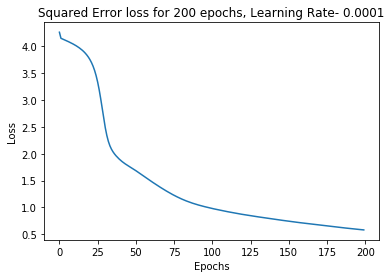

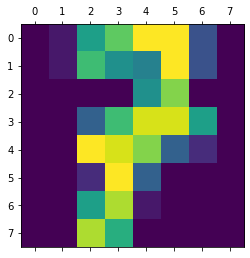

Output: [[7.15594928]]
Prediction: [[7.]]
Actual Label: 7
[0 1 2 ... 8 8 8]
[0 1 2 ... 8 9 8]
Accuracy:47.13411240957151%


In [ ]:
plt.plot(Loss_SE6)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.0001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1201
a, pred1 = squarederror_neuralnet6.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred1)
print('Prediction:', np.round(pred1))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))

#Accuracy
prediction6 =[]
for i in range(train_X.shape[0]):
    _, b = squarederror_neuralnet6.predict(np.array(train_X[i]).reshape(64,1), softmax= False);
    t = int(np.round(b)[0]);
    prediction6.append(t)
print(np.array(prediction1))
print(target)
from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction6)* 100)+'%' )


## V. Learning Rate- 0.00001

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet4 = Neural_Network(neurons, activation_functions)
Loss_SE4 = squarederror_neuralnet4.train(train_X, train_Y, lr = 0.00001, epochs = 200, minibatchsize = 1 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 4.562741236609444
Epoch: 1 Loss: 4.1080062742053425
Epoch: 2 Loss: 4.107959748410899
Epoch: 3 Loss: 4.107191434318062
Epoch: 4 Loss: 4.106415495202983
Epoch: 5 Loss: 4.10563963902447
Epoch: 6 Loss: 4.1048638929057235
Epoch: 7 Loss: 4.104088206910844
Epoch: 8 Loss: 4.10331253043086
Epoch: 9 Loss: 4.1025368129465605
Epoch: 10 Loss: 4.101761004031741
Epoch: 11 Loss: 4.100985053348812
Epoch: 12 Loss: 4.100208910644322
Epoch: 13 Loss: 4.099432525744469
Epoch: 14 Loss: 4.098655848550589
Epoch: 15 Loss: 4.097878829034641
Epoch: 16 Loss: 4.097101417234646
Epoch: 17 Loss: 4.096323563250112
Epoch: 18 Loss: 4.09554521723741
Epoch: 19 Loss: 4.094766329405131
Epoch: 20 Loss: 4.09398685000938
Epoch: 21 Loss: 4.09320672934904
Epoch: 22 Loss: 4.092425917760966
Epoch: 23 Loss: 4.091644365615147
Epoch: 24 Loss: 4.090862023309775
Epoch: 25 Loss: 4.090078841266288
Epoch: 26 Loss: 4.089294769924308
Epoch: 27 Loss: 4.088509759736531
Epoch: 28 Loss: 4.087723761163524
Epoch: 29 Loss: 4.08693672

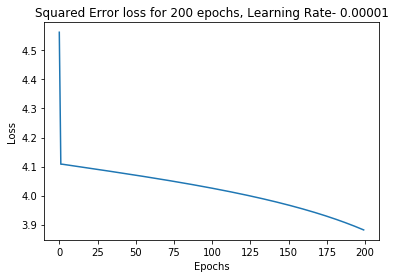

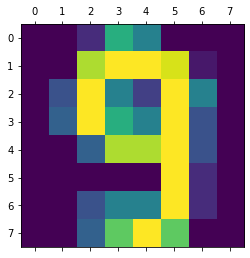

Output: [[4.76967033]]
Prediction: [[5.]]
Actual Label: 9


In [ ]:
plt.plot(Loss_SE4)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.00001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1795
a, pred1 = squarederror_neuralnet4.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred1)
print('Prediction:', np.round(pred1))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))


## VI. Learning Rate- 0.000001

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet5 = Neural_Network(neurons, activation_functions)
Loss_SE5 = squarederror_neuralnet5.train(train_X, train_Y, lr = 0.000001, epochs = 200, minibatchsize = 1 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 7.022186736819845
Epoch: 1 Loss: 5.406506435167713
Epoch: 2 Loss: 4.6768093059053335
Epoch: 3 Loss: 4.351666814970388
Epoch: 4 Loss: 4.208645270408077
Epoch: 5 Loss: 4.14642937046908
Epoch: 6 Loss: 4.119622140327786
Epoch: 7 Loss: 4.108169247206375
Epoch: 8 Loss: 4.103312042225959
Epoch: 9 Loss: 4.10126062409363
Epoch: 10 Loss: 4.1003886707254065
Epoch: 11 Loss: 4.100004318959233
Epoch: 12 Loss: 4.099816365909604
Epoch: 13 Loss: 4.099704078540146
Epoch: 14 Loss: 4.0996185610549905
Epoch: 15 Loss: 4.099540780788915
Epoch: 16 Loss: 4.099463859363331
Epoch: 17 Loss: 4.099385692907774
Epoch: 18 Loss: 4.099305934979906
Epoch: 19 Loss: 4.099224801679657
Epoch: 20 Loss: 4.099142624776767
Epoch: 21 Loss: 4.099059703249791
Epoch: 22 Loss: 4.098976267988082
Epoch: 23 Loss: 4.098892485268991
Epoch: 24 Loss: 4.098808470454969
Epoch: 25 Loss: 4.098724301868149
Epoch: 26 Loss: 4.098640031983471
Epoch: 27 Loss: 4.098555695664309
Epoch: 28 Loss: 4.098471315945239
Epoch: 29 Loss: 4.09838

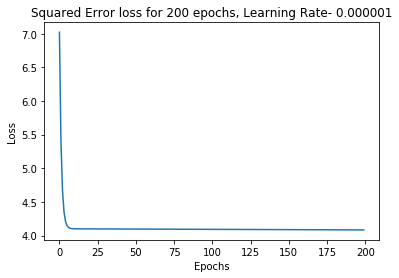

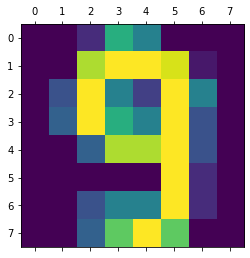

Output: [[4.54832374]]
Prediction: [[5.]]
Actual Label: 9


In [ ]:
plt.plot(Loss_SE5)
plt.title("Squared Error loss for 200 epochs, Learning Rate- 0.000001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1795
a, pred1 = squarederror_neuralnet5.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= False)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Output:', pred1)
print('Prediction:', np.round(pred1))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))


#Cross Entropy Loss - Varying Learning Rates

## I. Learning Rate - 0.1 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 
 
neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet1 = Neural_Network(neurons, activation_functions)
Loss1 = crossentropy_neuralnet1.train(train_X, train_Y, 0.1, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)

Epoch: 0 Loss: 2.3380117780217877
Epoch: 1 Loss: 2.3269442201583854
Epoch: 2 Loss: 2.326944220184614
Epoch: 3 Loss: 2.326944220184614
Epoch: 4 Loss: 2.3269442201846138
Epoch: 5 Loss: 2.326944220184614
Epoch: 6 Loss: 2.326944220184614
Epoch: 7 Loss: 2.326944220184614
Epoch: 8 Loss: 2.326944220184614
Epoch: 9 Loss: 2.3269442201846138
Epoch: 10 Loss: 2.326944220184614
Epoch: 11 Loss: 2.3269442201846138
Epoch: 12 Loss: 2.326944220184614
Epoch: 13 Loss: 2.326944220184614
Epoch: 14 Loss: 2.3269442201846138
Epoch: 15 Loss: 2.3269442201846138
Epoch: 16 Loss: 2.326944220184614
Epoch: 17 Loss: 2.326944220184614
Epoch: 18 Loss: 2.3269442201846138
Epoch: 19 Loss: 2.326944220184614
Epoch: 20 Loss: 2.3269442201846138
Epoch: 21 Loss: 2.326944220184614
Epoch: 22 Loss: 2.3269442201846138
Epoch: 23 Loss: 2.326944220184614
Epoch: 24 Loss: 2.326944220184614
Epoch: 25 Loss: 2.326944220184614
Epoch: 26 Loss: 2.326944220184614
Epoch: 27 Loss: 2.326944220184614
Epoch: 28 Loss: 2.326944220184614
Epoch: 29 Loss

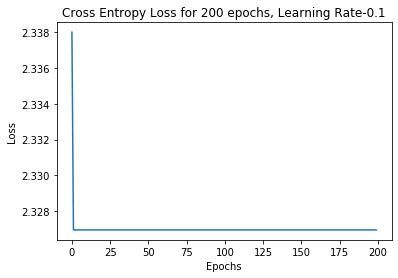

In [ ]:
plt.plot(Loss1)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.1")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## II. Learning Rate - 0.01

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet2 = Neural_Network(neurons, activation_functions)

In [ ]:
Loss2 = crossentropy_neuralnet2.train(train_X, train_Y, 0.01, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)

Epoch: 0 Loss: 2.3268607115394366
Epoch: 1 Loss: 2.0697866226587016
Epoch: 2 Loss: 1.8355783893325701
Epoch: 3 Loss: 1.690293093831064
Epoch: 4 Loss: 1.576262755422366
Epoch: 5 Loss: 1.3303928545518569
Epoch: 6 Loss: 0.9859061890515082
Epoch: 7 Loss: 0.6030252525402019
Epoch: 8 Loss: 0.38207887020872655
Epoch: 9 Loss: 0.2980110208075762
Epoch: 10 Loss: 0.2435884846919492
Epoch: 11 Loss: 0.20238768667318635
Epoch: 12 Loss: 0.1709909494198871
Epoch: 13 Loss: 0.14559074319148965
Epoch: 14 Loss: 0.1235057329434305
Epoch: 15 Loss: 0.10519968100145691
Epoch: 16 Loss: 0.0906160213960358
Epoch: 17 Loss: 0.07800433689627627
Epoch: 18 Loss: 0.0673109888792053
Epoch: 19 Loss: 0.05923833500656478
Epoch: 20 Loss: 0.0513758117691304
Epoch: 21 Loss: 0.04595292077746659
Epoch: 22 Loss: 0.04132587725397382
Epoch: 23 Loss: 0.03631000617313828
Epoch: 24 Loss: 0.03235988232348036
Epoch: 25 Loss: 0.027479224482765536
Epoch: 26 Loss: 0.024123364830759244
Epoch: 27 Loss: 0.021124417412760912
Epoch: 28 Loss: 

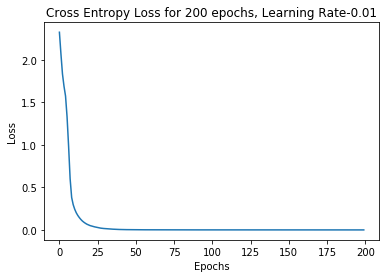

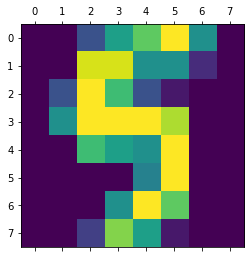

Input: [[0.     0.     0.25   0.5625 0.75   1.     0.5    0.     0.     0.
  0.9375 0.9375 0.5    0.5    0.125  0.     0.     0.25   1.     0.6875
  0.25   0.0625 0.     0.     0.     0.5    1.     1.     1.     0.875
  0.     0.     0.     0.     0.6875 0.5625 0.5    1.     0.     0.
  0.     0.     0.     0.     0.4375 1.     0.     0.     0.     0.
  0.     0.5    1.     0.75   0.     0.     0.     0.     0.1875 0.8125
  0.5625 0.0625 0.     0.    ]]
Actual Label: 5
Predicted Label: 5
[0 1 2 ... 8 9 8]
[0 1 2 ... 8 9 8]
Accuracy:100.0%  Number of correctly predicted samples:1797


In [ ]:
plt.plot(Loss2)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.01")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1700
X_data, predict = crossentropy_neuralnet2.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= True)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Input:', np.resize(X_data, (1, X_data.shape[0])))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))
print('Predicted Label:', np.argmax(predict, axis = 0)[0])

#Accuracy
prediction2 =[]
for i in range(1797):
    _, b = crossentropy_neuralnet2.predict(np.array(train_X[i]).reshape(64,1), softmax= True);
    k = np.argmax(b, axis=0)[0];
    prediction2.append(k)
print(np.array(prediction))
print(target)

from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction2)*100)+'%' + '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction2, normalize = False)))

## III. Learning Rate - 0.001 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet3 = Neural_Network(neurons, activation_functions)
Loss3 = crossentropy_neuralnet3.train(train_X, train_Y, 0.001, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)

Epoch: 0 Loss: 2.3512916777100386
Epoch: 1 Loss: 2.3420316179069873
Epoch: 2 Loss: 2.3347540158721816
Epoch: 3 Loss: 2.328973595498726
Epoch: 4 Loss: 2.3243516852225006
Epoch: 5 Loss: 2.3206392587577396
Epoch: 6 Loss: 2.3176503230313954
Epoch: 7 Loss: 2.315243136651232
Epoch: 8 Loss: 2.313304647180367
Epoch: 9 Loss: 2.3117380884901686
Epoch: 10 Loss: 2.3104554816011857
Epoch: 11 Loss: 2.3093758729388036
Epoch: 12 Loss: 2.308427583357312
Epoch: 13 Loss: 2.3075507422839974
Epoch: 14 Loss: 2.3066968546027846
Epoch: 15 Loss: 2.3058242114705014
Epoch: 16 Loss: 2.3048899292279597
Epoch: 17 Loss: 2.3038393180488557
Epoch: 18 Loss: 2.3025910715795126
Epoch: 19 Loss: 2.301011874962407
Epoch: 20 Loss: 2.2988674541220977
Epoch: 21 Loss: 2.2957184005697995
Epoch: 22 Loss: 2.2906830251779757
Epoch: 23 Loss: 2.2819582986892923
Epoch: 24 Loss: 2.2662032761544806
Epoch: 25 Loss: 2.236836606786988
Epoch: 26 Loss: 2.187332650812276
Epoch: 27 Loss: 2.124785001217596
Epoch: 28 Loss: 2.0669134397541518
Epo

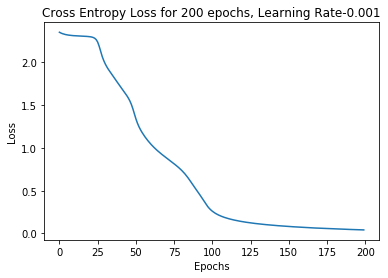

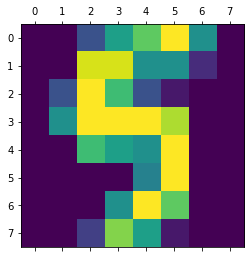

Input: [[0.     0.     0.25   0.5625 0.75   1.     0.5    0.     0.     0.
  0.9375 0.9375 0.5    0.5    0.125  0.     0.     0.25   1.     0.6875
  0.25   0.0625 0.     0.     0.     0.5    1.     1.     1.     0.875
  0.     0.     0.     0.     0.6875 0.5625 0.5    1.     0.     0.
  0.     0.     0.     0.     0.4375 1.     0.     0.     0.     0.
  0.     0.5    1.     0.75   0.     0.     0.     0.     0.1875 0.8125
  0.5625 0.0625 0.     0.    ]]
Actual Label: 5
Predicted Label: 5
[0 1 2 ... 8 9 8]
[0 1 2 ... 8 9 8]
Accuracy:98.88703394546467%


In [ ]:
plt.plot(Loss3)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tr_eg = 1700
X_data, predict3 = crossentropy_neuralnet3.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= True)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Input:', np.resize(X_data, (1, X_data.shape[0])))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))
print('Predicted Label:', np.argmax(predict3, axis = 0)[0])

#Accuracy
prediction3 =[]
for i in range(1797):
    _, c = crossentropy_neuralnet3.predict(np.array(train_X[i]).reshape(64,1), softmax= True);
    t = np.argmax(c, axis=0)[0];
    prediction3.append(t)
print(np.array(prediction3))
print(target)

from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction3)* 100)+'%'+ '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction, normalize = False)))

## IV. Learning Rate- 0.0001

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet6 = Neural_Network(neurons, activation_functions)

In [ ]:
Loss6 = crossentropy_neuralnet6.train(train_X, train_Y, 0.0001, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.31637720379979
Epoch: 1 Loss: 2.3097608918162833
Epoch: 2 Loss: 2.3097756133297027
Epoch: 3 Loss: 2.3097410039530866
Epoch: 4 Loss: 2.3097052974401544
Epoch: 5 Loss: 2.309669590606782
Epoch: 6 Loss: 2.3096339008014866
Epoch: 7 Loss: 2.309598222478727
Epoch: 8 Loss: 2.309562549597204
Epoch: 9 Loss: 2.30952687609538
Epoch: 10 Loss: 2.3094911958998403
Epoch: 11 Loss: 2.309455502923611
Epoch: 12 Loss: 2.3094197910642547
Epoch: 13 Loss: 2.309384054201939
Epoch: 14 Loss: 2.3093482861974928
Epoch: 15 Loss: 2.309312480890443
Epoch: 16 Loss: 2.3092766320970255
Epoch: 17 Loss: 2.30924073360818
Epoch: 18 Loss: 2.309204779187513
Epoch: 19 Loss: 2.309168762569242
Epoch: 20 Loss: 2.3091326774561
Epoch: 21 Loss: 2.3090965175172196
Epoch: 22 Loss: 2.3090602763859747
Epoch: 23 Loss: 2.3090239476577907
Epoch: 24 Loss: 2.3089875248879195
Epoch: 25 Loss: 2.308951001589169
Epoch: 26 Loss: 2.3089143712295868
Epoch: 27 Loss: 2.3088776272301095
Epoch: 28 Loss: 2.3088407629621535
Epoch: 29 Los

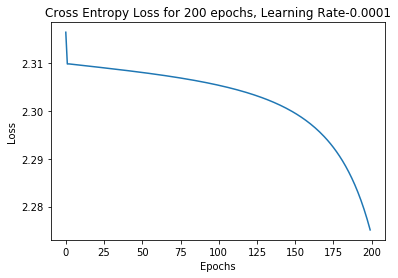

In [ ]:
plt.plot(Loss6)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.0001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## V. Learning Rate - 0.00001 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet4 = Neural_Network(neurons, activation_functions)


In [ ]:
Loss4 = crossentropy_neuralnet4.train(train_X, train_Y, 0.00001, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.326065396231668
Epoch: 1 Loss: 2.312986277648656
Epoch: 2 Loss: 2.3074919353699563
Epoch: 3 Loss: 2.305169034378303
Epoch: 4 Loss: 2.3041883429085406
Epoch: 5 Loss: 2.30377690754425
Epoch: 6 Loss: 2.303606166444152
Epoch: 7 Loss: 2.303536457887038
Epoch: 8 Loss: 2.3035086271175973
Epoch: 9 Loss: 2.3034977925019176
Epoch: 10 Loss: 2.3034936091320923
Epoch: 11 Loss: 2.303491857552305
Epoch: 12 Loss: 2.3034908720675555
Epoch: 13 Loss: 2.3034900332973414
Epoch: 14 Loss: 2.303489138138422
Epoch: 15 Loss: 2.3034881405768104
Epoch: 16 Loss: 2.3034870478480625
Epoch: 17 Loss: 2.303485880741841
Epoch: 18 Loss: 2.3034846597663203
Epoch: 19 Loss: 2.30348340131145
Epoch: 20 Loss: 2.3034821173805278
Epoch: 21 Loss: 2.303480816378484
Epoch: 22 Loss: 2.303479504042224
Epoch: 23 Loss: 2.303478184227737
Epoch: 24 Loss: 2.3034768595019197
Epoch: 25 Loss: 2.30347553156291
Epoch: 26 Loss: 2.3034742015294114
Epoch: 27 Loss: 2.303472870136182
Epoch: 28 Loss: 2.303471537864628
Epoch: 29 Loss

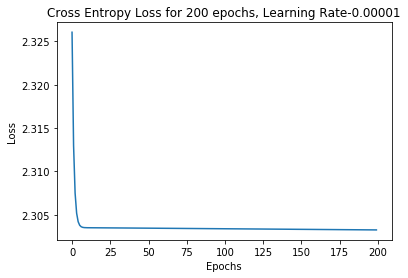

In [ ]:
plt.plot(Loss4)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.00001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## VI. Learning Rate - 0.000001 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet5 = Neural_Network(neurons, activation_functions)


In [ ]:
Loss5 = crossentropy_neuralnet5.train(train_X, train_Y, 0.000001, 200, 1,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.3511302141382795
Epoch: 1 Loss: 2.3470594377498104
Epoch: 2 Loss: 2.343346042346775
Epoch: 3 Loss: 2.3399559316501763
Epoch: 4 Loss: 2.336858678832443
Epoch: 5 Loss: 2.334027071428831
Epoch: 6 Loss: 2.331436720914511
Epoch: 7 Loss: 2.3290657266508665
Epoch: 8 Loss: 2.326894385704081
Epoch: 9 Loss: 2.3249049414973944
Epoch: 10 Loss: 2.323081365445523
Epoch: 11 Loss: 2.3214091666897456
Epoch: 12 Loss: 2.3198752258480906
Epoch: 13 Loss: 2.318467649350281
Epoch: 14 Loss: 2.317175641468502
Epoch: 15 Loss: 2.3159893916038072
Epoch: 16 Loss: 2.3148999747611168
Epoch: 17 Loss: 2.3138992634569697
Epoch: 18 Loss: 2.312979849564452
Epoch: 19 Loss: 2.312134974818074
Epoch: 20 Loss: 2.3113584688849125
Epoch: 21 Loss: 2.3106446940631664
Epoch: 22 Loss: 2.309988495800112
Epoch: 23 Loss: 2.3093851583323093
Epoch: 24 Loss: 2.308830364845108
Epoch: 25 Loss: 2.308320161628666
Epoch: 26 Loss: 2.3078509257761484
Epoch: 27 Loss: 2.3074193360282558
Epoch: 28 Loss: 2.30702234641846
Epoch: 29 

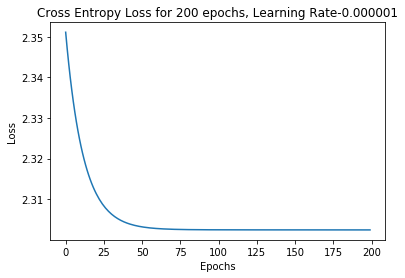

In [ ]:
plt.plot(Loss5)
plt.title("Cross Entropy Loss for 200 epochs, Learning Rate-0.000001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training over different mini batch sizes

## I. Minibatch Size = 50

### i) Cross Entropy 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet_ = Neural_Network(neurons, activation_functions)
Loss_ = crossentropy_neuralnet_.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 50,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.3992180320926537
Epoch: 1 Loss: 2.3513658990115065
Epoch: 2 Loss: 2.3354352674053924
Epoch: 3 Loss: 2.327032604555089
Epoch: 4 Loss: 2.3217276203872843
Epoch: 5 Loss: 2.317982152155088
Epoch: 6 Loss: 2.3150899803106677
Epoch: 7 Loss: 2.3126750559401636
Epoch: 8 Loss: 2.3104970832976965
Epoch: 9 Loss: 2.3083588457459454
Epoch: 10 Loss: 2.306049777542241
Epoch: 11 Loss: 2.303283568746292
Epoch: 12 Loss: 2.299585273576761
Epoch: 13 Loss: 2.2940232319214355
Epoch: 14 Loss: 2.2845004590685414
Epoch: 15 Loss: 2.2659540527361144
Epoch: 16 Loss: 2.227371371674483
Epoch: 17 Loss: 2.159460046073194
Epoch: 18 Loss: 2.088348210500362
Epoch: 19 Loss: 2.031410274971427
Epoch: 20 Loss: 1.9881147788650904
Epoch: 21 Loss: 1.9542328318200104
Epoch: 22 Loss: 1.9272697642329735
Epoch: 23 Loss: 1.904800853273615
Epoch: 24 Loss: 1.8855110939746984
Epoch: 25 Loss: 1.8683557146967362
Epoch: 26 Loss: 1.85270776209059
Epoch: 27 Loss: 1.8378673447153853
Epoch: 28 Loss: 1.8234373020633567
Epoch: 

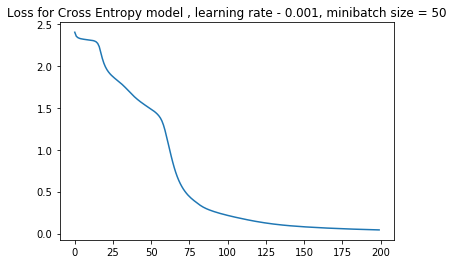

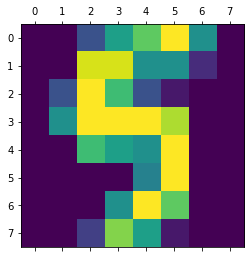

Input: [[0.     0.     0.25   0.5625 0.75   1.     0.5    0.     0.     0.
  0.9375 0.9375 0.5    0.5    0.125  0.     0.     0.25   1.     0.6875
  0.25   0.0625 0.     0.     0.     0.5    1.     1.     1.     0.875
  0.     0.     0.     0.     0.6875 0.5625 0.5    1.     0.     0.
  0.     0.     0.     0.     0.4375 1.     0.     0.     0.     0.
  0.     0.5    1.     0.75   0.     0.     0.     0.     0.1875 0.8125
  0.5625 0.0625 0.     0.    ]]
Actual Label: 5
Predicted Label: 5
[0 1 2 ... 8 9 8]
[0 1 2 ... 8 9 8]
Accuracy:98.49749582637729%  Number of correctly predicted samples:1770


In [ ]:
plt.plot(Loss_)
plt.title("Loss for Cross Entropy model , learning rate - 0.001, minibatch size = 50")
plt.show()
tr_eg = 1700
X_data, predict = crossentropy_neuralnet_.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= True)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Input:', np.resize(X_data, (1, X_data.shape[0])))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))
print('Predicted Label:', np.argmax(predict, axis = 0)[0])

      
#Accuracy
prediction =[]
for i in range(1797):
    _, b = crossentropy_neuralnet_.predict(np.array(train_X[i]).reshape(64,1), softmax= True);
    k = np.argmax(b, axis=0)[0];
    prediction.append(k)
print(np.array(prediction))
print(target)

from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction)*100)+'%' + '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction, normalize = False)))



### ii) Squared Error

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet_1 = Neural_Network(neurons, activation_functions)
Loss_SE_1 = squarederror_neuralnet_1.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 50 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 4.359592185673637
Epoch: 1 Loss: 4.202633827327585
Epoch: 2 Loss: 4.183050400787341
Epoch: 3 Loss: 4.165309669624542
Epoch: 4 Loss: 4.148872282700089
Epoch: 5 Loss: 4.13333898890302
Epoch: 6 Loss: 4.11839552959953
Epoch: 7 Loss: 4.103779845775696
Epoch: 8 Loss: 4.089260954172047
Epoch: 9 Loss: 4.074624083881042
Epoch: 10 Loss: 4.059659078432706
Epoch: 11 Loss: 4.044150222035823
Epoch: 12 Loss: 4.027866182511711
Epoch: 13 Loss: 4.010548949706263
Epoch: 14 Loss: 3.991900580643692
Epoch: 15 Loss: 3.971566572809263
Epoch: 16 Loss: 3.949118510566246
Epoch: 17 Loss: 3.9240214006755942
Epoch: 18 Loss: 3.8956035844917047
Epoch: 19 Loss: 3.862988050343768
Epoch: 20 Loss: 3.825023471184363
Epoch: 21 Loss: 3.7801740270203124
Epoch: 22 Loss: 3.726369982073046
Epoch: 23 Loss: 3.6608405218772955
Epoch: 24 Loss: 3.5799453227191247
Epoch: 25 Loss: 3.4791874917773256
Epoch: 26 Loss: 3.353593053674115
Epoch: 27 Loss: 3.1995578429959664
Epoch: 28 Loss: 3.0189811462306957
Epoch: 29 Loss: 2.

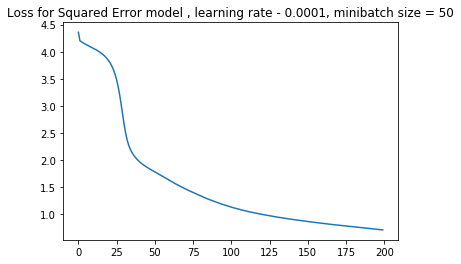

In [ ]:
plt.plot(Loss_SE_1)
plt.title("Loss for Squared Error model , learning rate - 0.0001, minibatch size = 50")
plt.show()

## II. Minibatch Size = 100

### i) Cross Entropy

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet_1 = Neural_Network(neurons, activation_functions)
Loss_1 = crossentropy_neuralnet_1.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 100,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.4951864943556457
Epoch: 1 Loss: 2.3386803785969104
Epoch: 2 Loss: 2.326849442751229
Epoch: 3 Loss: 2.320306135570635
Epoch: 4 Loss: 2.3160046963600562
Epoch: 5 Loss: 2.3127812856778616
Epoch: 6 Loss: 2.3100465665200405
Epoch: 7 Loss: 2.3074173372576015
Epoch: 8 Loss: 2.3045565848548293
Epoch: 9 Loss: 2.3010419553621793
Epoch: 10 Loss: 2.296164864641377
Epoch: 11 Loss: 2.2885118933843356
Epoch: 12 Loss: 2.2749176542598715
Epoch: 13 Loss: 2.2480204128595904
Epoch: 14 Loss: 2.194523458854061
Epoch: 15 Loss: 2.112633031337983
Epoch: 16 Loss: 2.0503762746004495
Epoch: 17 Loss: 2.0040752410312868
Epoch: 18 Loss: 1.9614143583790964
Epoch: 19 Loss: 1.9293630126255752
Epoch: 20 Loss: 1.901383463773102
Epoch: 21 Loss: 1.8750200999652624
Epoch: 22 Loss: 1.8487594478357883
Epoch: 23 Loss: 1.8224544718299254
Epoch: 24 Loss: 1.7964464562319797
Epoch: 25 Loss: 1.7709972668418885
Epoch: 26 Loss: 1.7467548284043972
Epoch: 27 Loss: 1.7241854455019596
Epoch: 28 Loss: 1.7029030707631514
E

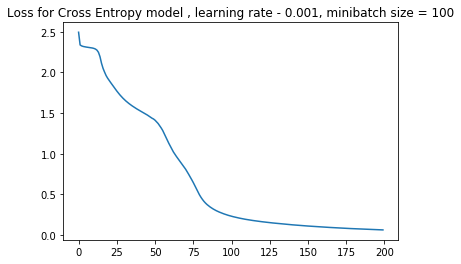

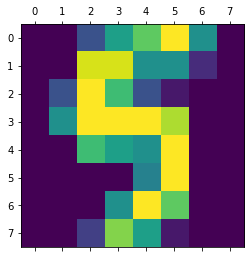

Input: [[0.     0.     0.25   0.5625 0.75   1.     0.5    0.     0.     0.
  0.9375 0.9375 0.5    0.5    0.125  0.     0.     0.25   1.     0.6875
  0.25   0.0625 0.     0.     0.     0.5    1.     1.     1.     0.875
  0.     0.     0.     0.     0.6875 0.5625 0.5    1.     0.     0.
  0.     0.     0.     0.     0.4375 1.     0.     0.     0.     0.
  0.     0.5    1.     0.75   0.     0.     0.     0.     0.1875 0.8125
  0.5625 0.0625 0.     0.    ]]
Actual Label: 5
Predicted Label: 5
[0 1 2 ... 8 9 8]
[0 1 2 ... 8 9 8]
Accuracy:98.05230940456316%  Number of correctly predicted samples:1762


In [ ]:
plt.plot(Loss_1)
plt.title("Loss for Cross Entropy model , learning rate - 0.001, minibatch size = 100")
plt.show()

tr_eg = 1700
X_data, predict = crossentropy_neuralnet_1.predict(np.array(train_X[tr_eg]).reshape(64,1), softmax= True)
plt.matshow(np.resize(train_X[tr_eg],(8,8)))
plt.show()
print('Input:', np.resize(X_data, (1, X_data.shape[0])))
print('Actual Label:', np.argmax(train_Y[tr_eg,:], axis = 0))
print('Predicted Label:', np.argmax(predict, axis = 0)[0])

#Accuracy
prediction =[]
for i in range(1797):
    _, b = crossentropy_neuralnet_1.predict(np.array(train_X[i]).reshape(64,1), softmax= True);
    k = np.argmax(b, axis=0)[0];
    prediction.append(k)
print(np.array(prediction))
print(target)

from sklearn.metrics import accuracy_score
print('Accuracy:'+ str(accuracy_score(target, prediction)*100)+'%' + '  Number of correctly predicted samples:'+ str(accuracy_score(target, prediction, normalize = False)))


### ii) Squared Error

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet_2 = Neural_Network(neurons, activation_functions)
Loss_SE_2 = squarederror_neuralnet_2.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 100 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 4.866203533097218
Epoch: 1 Loss: 4.192071167863064
Epoch: 2 Loss: 4.171742045310598
Epoch: 3 Loss: 4.154456922434191
Epoch: 4 Loss: 4.139178718376049
Epoch: 5 Loss: 4.125138166306814
Epoch: 6 Loss: 4.1117976520721635
Epoch: 7 Loss: 4.098754493713225
Epoch: 8 Loss: 4.08568282100176
Epoch: 9 Loss: 4.072297008918417
Epoch: 10 Loss: 4.058326498537669
Epoch: 11 Loss: 4.043496075055706
Epoch: 12 Loss: 4.027507866361035
Epoch: 13 Loss: 4.010022389376374
Epoch: 14 Loss: 3.9906357240040222
Epoch: 15 Loss: 3.9688500699205758
Epoch: 16 Loss: 3.944040289935567
Epoch: 17 Loss: 3.9154019902482577
Epoch: 18 Loss: 3.881899471321422
Epoch: 19 Loss: 3.8421232426268364
Epoch: 20 Loss: 3.7941423905325866
Epoch: 21 Loss: 3.7353267039521643
Epoch: 22 Loss: 3.6622034234017615
Epoch: 23 Loss: 3.57036386316688
Epoch: 24 Loss: 3.4548736998326826
Epoch: 25 Loss: 3.3126642860077
Epoch: 26 Loss: 3.1484174530707576
Epoch: 27 Loss: 2.980776357514816
Epoch: 28 Loss: 2.818326380470016
Epoch: 29 Loss: 2.

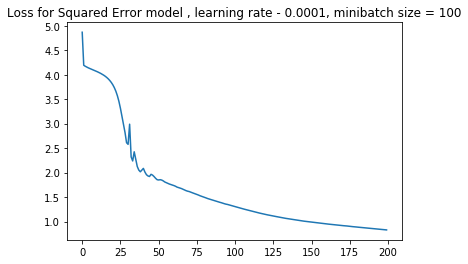

In [ ]:
plt.plot(Loss_SE_2)
plt.title("Loss for Squared Error model , learning rate - 0.0001, minibatch size = 100")
plt.show()

## III. Minibatch Size = 200

### i) Cross Entropy 

Epoch: 0 Loss: 2.7731457703820452
Epoch: 1 Loss: 2.3199986824050467
Epoch: 2 Loss: 2.3120384196293733
Epoch: 3 Loss: 2.306637661685078
Epoch: 4 Loss: 2.304472462610268
Epoch: 5 Loss: 2.3037374135896442
Epoch: 6 Loss: 2.3037047407149873
Epoch: 7 Loss: 2.3033662423236194
Epoch: 8 Loss: 2.303260589007413
Epoch: 9 Loss: 2.3029632523226318
Epoch: 10 Loss: 2.3025278108824994
Epoch: 11 Loss: 2.302172729200366
Epoch: 12 Loss: 2.30146554521148
Epoch: 13 Loss: 2.3005201481858903
Epoch: 14 Loss: 2.299345779248973
Epoch: 15 Loss: 2.297175994896987
Epoch: 16 Loss: 2.2938631545284163
Epoch: 17 Loss: 2.2886090592630044
Epoch: 18 Loss: 2.278167209319202
Epoch: 19 Loss: 2.2614547336805946
Epoch: 20 Loss: 2.2504180210816633
Epoch: 21 Loss: 2.2303098714998755
Epoch: 22 Loss: 2.226976230975663
Epoch: 23 Loss: 2.157310865176026
Epoch: 24 Loss: 2.106178014382127
Epoch: 25 Loss: 2.0286062128585716
Epoch: 26 Loss: 1.9995306020434813
Epoch: 27 Loss: 1.9397045000306194
Epoch: 28 Loss: 1.8912253046359813
Epoch: 

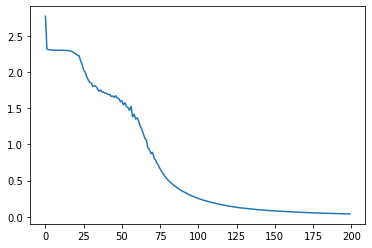

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet_2 = Neural_Network(neurons, activation_functions)
Loss_2 = crossentropy_neuralnet_2.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 200,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)
plt.plot(Loss_2)
plt.show()

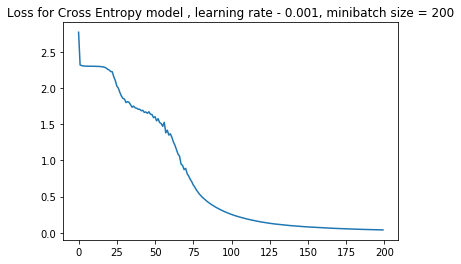

In [ ]:
plt.plot(Loss_2)
plt.title("Loss for Cross Entropy model , learning rate - 0.001, minibatch size = 200")
plt.show()

### ii) Squared Error

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet_3 = Neural_Network(neurons, activation_functions)
Loss_SE_3 = squarederror_neuralnet_3.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 200 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 18.000190581747976
Epoch: 1 Loss: 9.755346902917871
Epoch: 2 Loss: 8.032116491025139
Epoch: 3 Loss: 6.833920690454704
Epoch: 4 Loss: 6.0008494205191525
Epoch: 5 Loss: 5.4216869315710134
Epoch: 6 Loss: 5.019085447993628
Epoch: 7 Loss: 4.739252848552859
Epoch: 8 Loss: 4.544780082602144
Epoch: 9 Loss: 4.409652420329699
Epoch: 10 Loss: 4.315779656298165
Epoch: 11 Loss: 4.250582807219457
Epoch: 12 Loss: 4.205315640534998
Epoch: 13 Loss: 4.17389730147929
Epoch: 14 Loss: 4.152100422663851
Epoch: 15 Loss: 4.136986478717621
Epoch: 16 Loss: 4.126513102669342
Epoch: 17 Loss: 4.119261001972731
Epoch: 18 Loss: 4.114244054840125
Epoch: 19 Loss: 4.110777256433633
Epoch: 20 Loss: 4.108384897222128
Epoch: 21 Loss: 4.10673672031081
Epoch: 22 Loss: 4.105603535722222
Epoch: 23 Loss: 4.104826364728859
Epoch: 24 Loss: 4.104294992288916
Epoch: 25 Loss: 4.10393306099552
Epoch: 26 Loss: 4.103687713049231
Epoch: 27 Loss: 4.103522393991506
Epoch: 28 Loss: 4.103411854245814
Epoch: 29 Loss: 4.103338

KeyboardInterrupt: 

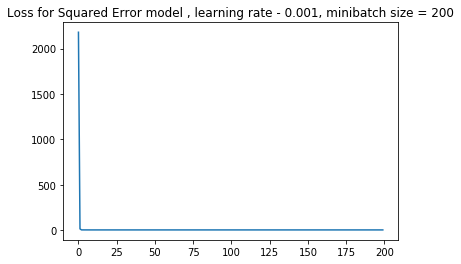

In [ ]:
plt.plot(Loss_SE_3)
plt.title("Loss for Squared Error model , learning rate - 0.0001, minibatch size = 200")
plt.show()

## IV. Minibatch Size = 300

### i) Cross Entropy 

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet_3 = Neural_Network(neurons, activation_functions)
Loss_3 = crossentropy_neuralnet_3.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 300,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)


Epoch: 0 Loss: 2.9516541959875053
Epoch: 1 Loss: 2.314988550331609
Epoch: 2 Loss: 2.3110976737673234
Epoch: 3 Loss: 2.3084942132892468
Epoch: 4 Loss: 2.306735265401164
Epoch: 5 Loss: 2.3055383385043786
Epoch: 6 Loss: 2.304719329117792
Epoch: 7 Loss: 2.3041564512834487
Epoch: 8 Loss: 2.3037682139715523
Epoch: 9 Loss: 2.3034996136910015
Epoch: 10 Loss: 2.30331327990516
Epoch: 11 Loss: 2.3031836918058177
Epoch: 12 Loss: 2.3030933498794606
Epoch: 13 Loss: 2.3030302151519457
Epoch: 14 Loss: 2.3029859825687296
Epoch: 15 Loss: 2.3029549094866346
Epoch: 16 Loss: 2.302933016869505
Epoch: 17 Loss: 2.3029175424628137
Epoch: 18 Loss: 2.3029065652657894
Epoch: 19 Loss: 2.3028987469646363
Epoch: 20 Loss: 2.302893153508521
Epoch: 21 Loss: 2.3028891317580595
Epoch: 22 Loss: 2.3028862240682373
Epoch: 23 Loss: 2.3028841090527323
Epoch: 24 Loss: 2.3028825604485292
Epoch: 25 Loss: 2.3028814185124378
Epoch: 26 Loss: 2.3028805701055775
Epoch: 27 Loss: 2.3028799348082525
Epoch: 28 Loss: 2.3028794552253724
Ep

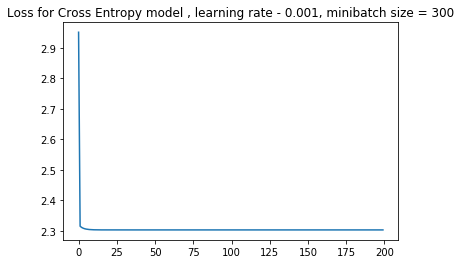

In [ ]:
plt.plot(Loss_3)
plt.title("Loss for Cross Entropy model , learning rate - 0.001, minibatch size = 300")
plt.show()

### ii) Squared Error

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet_4 = Neural_Network(neurons, activation_functions)
Loss_SE_4 = squarederror_neuralnet_4.train(train_X, train_Y, lr = 0.0001, epochs = 200, minibatchsize = 300 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

In [ ]:
plt.plot(Loss_SE_4)
plt.title("Loss for Squared Error model , learning rate - 0.001, minibatch size = 300")
plt.show()

## V. Minibatch Size = 500

### i) Cross Entropy 

Epoch: 0 Loss: 2.8080569647758575
Epoch: 1 Loss: 2.3171098157875205
Epoch: 2 Loss: 2.312813167801105
Epoch: 3 Loss: 2.309820462744236
Epoch: 4 Loss: 2.3077338462632735
Epoch: 5 Loss: 2.306278233028106
Epoch: 6 Loss: 2.305262607195127
Epoch: 7 Loss: 2.304553970222122
Epoch: 8 Loss: 2.304059573078914
Epoch: 9 Loss: 2.303714683881609
Epoch: 10 Loss: 2.303474111849794
Epoch: 11 Loss: 2.3033063095027675
Epoch: 12 Loss: 2.303189258571728
Epoch: 13 Loss: 2.303107596367863
Epoch: 14 Loss: 2.3030506075256962
Epoch: 15 Loss: 2.3030108204850026
Epoch: 16 Loss: 2.3029830268812947
Epoch: 17 Loss: 2.3029635967155038
Epoch: 18 Loss: 2.3029500003308585
Epoch: 19 Loss: 2.302940474916894
Epoch: 20 Loss: 2.3029337919567485
Epoch: 21 Loss: 2.3029290951340573
Epoch: 22 Loss: 2.302925787392648
Epoch: 23 Loss: 2.302923452266976
Epoch: 24 Loss: 2.3029217990958952
Epoch: 25 Loss: 2.3029206248741456
Epoch: 26 Loss: 2.302919787690378
Epoch: 27 Loss: 2.3029191882320723
Epoch: 28 Loss: 2.3029187569059157
Epoch: 29

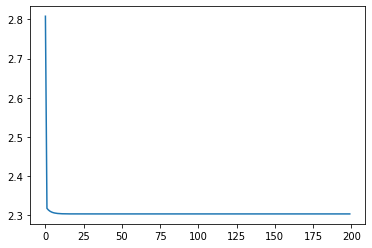

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 10  #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
crossentropy_neuralnet_4 = Neural_Network(neurons, activation_functions)
Loss_4 = crossentropy_neuralnet_4.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 200,  minibatch = True,softmax = True, crossentropy = True , onehotencoded = True)
plt.plot(Loss_4)

plt.show()

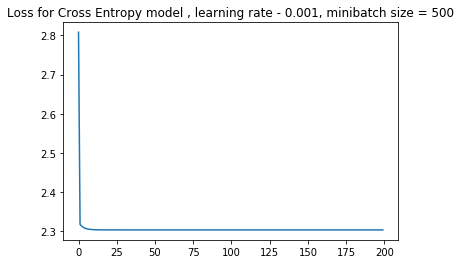

In [ ]:
plt.plot(Loss_4)
plt.title("Loss for Cross Entropy model , learning rate - 0.001, minibatch size = 500")
plt.show()

### ii) Squared Error

In [ ]:
inputsize = 64
D_in, H1, H2, D_out = inputsize, 256, 128, 1  

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['ReLU','ReLU', 'linear'] #activations in each layer (Note: the input layer does not have any activation)
squarederror_neuralnet_5 = Neural_Network(neurons, activation_functions)
Loss_SE_5 = squarederror_neuralnet_5.train(train_X, train_Y, lr = 0.001, epochs = 200, minibatchsize = 500 , minibatch = True,softmax = False,  crossentropy = False, onehotencoded = False)

Epoch: 0 Loss: 101776.85010603699
Epoch: 1 Loss: 3215.921518722184
Epoch: 2 Loss: 28.95621691155725
Epoch: 3 Loss: 4.288350604433117
Epoch: 4 Loss: 4.092762014561869
Epoch: 5 Loss: 4.090803255490937
Epoch: 6 Loss: 4.090748724934101
Epoch: 7 Loss: 4.090744841134908
Epoch: 8 Loss: 4.090744506858212
Epoch: 9 Loss: 4.090744477537795
Epoch: 10 Loss: 4.0907444749616815
Epoch: 11 Loss: 4.090744474735309
Epoch: 12 Loss: 4.090744474715416
Epoch: 13 Loss: 4.090744474713668
Epoch: 14 Loss: 4.090744474713515
Epoch: 15 Loss: 4.090744474713501
Epoch: 16 Loss: 4.0907444747135
Epoch: 17 Loss: 4.0907444747135
Epoch: 18 Loss: 4.0907444747135
Epoch: 19 Loss: 4.0907444747135
Epoch: 20 Loss: 4.0907444747135
Epoch: 21 Loss: 4.0907444747135
Epoch: 22 Loss: 4.0907444747135
Epoch: 23 Loss: 4.0907444747135
Epoch: 24 Loss: 4.0907444747135
Epoch: 25 Loss: 4.0907444747135
Epoch: 26 Loss: 4.0907444747135
Epoch: 27 Loss: 4.0907444747135
Epoch: 28 Loss: 4.0907444747135
Epoch: 29 Loss: 4.0907444747135
Epoch: 30 Loss: 

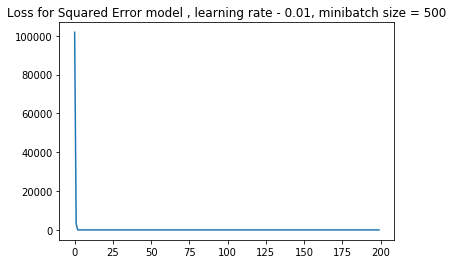

In [ ]:
plt.plot(Loss_SE_5)
plt.title("Loss for Squared Error model , learning rate - 0.01, minibatch size = 500")
plt.show()

# A comparison of different Mini Batch Sizes

##  I. Cross Entropy

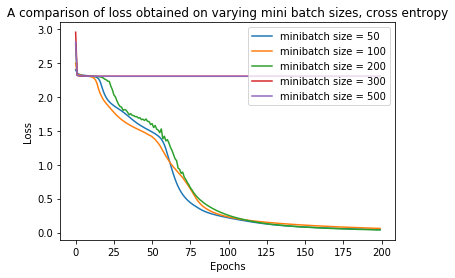

In [ ]:
plt.plot(Loss_ , Label = 'minibatch size = 50')
plt.plot(Loss_1 , Label = 'minibatch size = 100')
plt.plot(Loss_2, Label = 'minibatch size = 200')
plt.plot(Loss_3 , Label = 'minibatch size = 300')
plt.plot(Loss_4 , Label = 'minibatch size = 500')
plt.legend(loc ='upper right')
plt.title("A comparison of loss obtained on varying mini batch sizes, cross entropy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## II. Squared Error

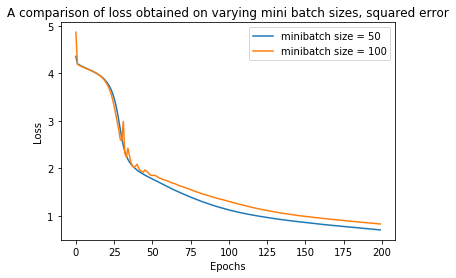

In [ ]:
plt.plot(Loss_SE_1 , Label = 'minibatch size = 50')
plt.plot(Loss_SE_2 , Label = 'minibatch size = 100')
plt.plot(Loss_SE_3, Label = 'minibatch size = 200')
plt.plot(Loss_SE_4 , Label = 'minibatch size = 300')
plt.plot(Loss_SE_5 , Label = 'minibatch size = 500')
plt.legend(loc ='upper right')
plt.title("A comparison of loss obtained on varying mini batch sizes, squared error")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
data = digits.data
target = digits.target
train_X = np.divide(data, np.max(data))
train_Y = onehotencoding(target)

In [ ]:
train_X.shape, train_Y.shape

((1797, 64), (1797, 10))